In [1]:
#tensorflow settings
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
#some imports

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

In [3]:
#load data
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

#map to (-1,+1)
x_train, x_test=x_train/255.0*2-1, x_test/255.0*2-1
print("x_train.shape:",x_test.shape)

x_train.shape: (10000, 28, 28)


In [4]:
#flatten
N, H, W=x_train.shape
D=H*W
x_train=x_train.reshape(-1,D)
x_test=x_test.reshape(-1,D)

In [5]:
#dim of the latent space
latent_dim=100

In [6]:
#build a generator model
def build_generator(latent_dim):
  i=Input(shape=(latent_dim,))
  x=Dense(256)(i)
  x=LeakyReLU(alpha=0.2)(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(512)(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(1024)(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(H*W,activation='tanh')(x)
  model=Model(i,x)
  return model

In [7]:
#build a discriminator model
def build_discriminator(img_size):
  i=Input(shape=img_size)
  x=Dense(512)(i)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.4)(x)
  x=Dense(256)(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.4)(x)
  x=Dense(1,activation='sigmoid')(x)
  model=Model(i,x)
  return model

In [8]:
#combine models
discriminator=build_discriminator(D)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5),metrics=['accuracy'])

generator=build_generator(latent_dim)
z=Input(shape=(latent_dim,))
img=generator(z)
discriminator.trainable=False
fake_pred=discriminator(img)

combined_model=Model(z,fake_pred)
combined_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5))


In [9]:
#train settings
batch_size=64
epochs=10000
sample_interval=1000

ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

d_losses=[]
g_losses=[]

#store images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:
#generate random samples and sving them into a file
def sample_images(epoch):
  rows, cols=5,5
  noise=np.random.normal(0,1,(rows*cols,latent_dim))
  imgs=generator.predict(noise)

  imgs=0.5*imgs+0.5

  fig,axs=plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx+=1
  fig.savefig('gan_images/%d.png'%epoch)
  plt.close()

In [11]:
#train loop
for epoch in range(epochs):
  #train discriminator
  idx=np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs=x_train[idx]

  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=generator.predict(noise)

  #train discriminator
  d_loss_real, d_acc_real=discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake, d_acc_fake=discriminator.train_on_batch(fake_imgs,zeros)
  d_loss=0.5*(d_loss_real + d_loss_fake)
  d_acc=0.5*(d_acc_real + d_acc_fake)

  #train generator
  noise = tf.random.normal([batch_size, latent_dim])
  g_loss=combined_model.train_on_batch(noise,ones)

  #save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch%1000==0:
        print(f"epoch:{epoch+1}/{epochs},d_loss:{d_loss:.2f},d_acc:{d_acc: .2f},g_loss:{g_loss: .2f}")
  if epoch%sample_interval==0:
        sample_images(epoch)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
2/2 [==============================] - 0s 5ms/step
epoch:6001/10000,d_loss:0.73,d_acc: 0.39,g_loss: 0.76
2/2 [==============================] - 0s 5ms/step
epoch:7001/10000,d_loss:0.71,d_acc: 0.48,g_loss: 0.80
2/2 [==============================] - 0s 6ms/step
epoch:8001/10000,d_loss:0.72,d_acc: 0.40,g_loss: 0.79
2/2 [==============================] - 0s 6ms/step
epoch:9001/10000,d_loss:0.69,d_acc: 0.50,g_loss: 0.78
2/2 [==============================] - 0s 6ms/step


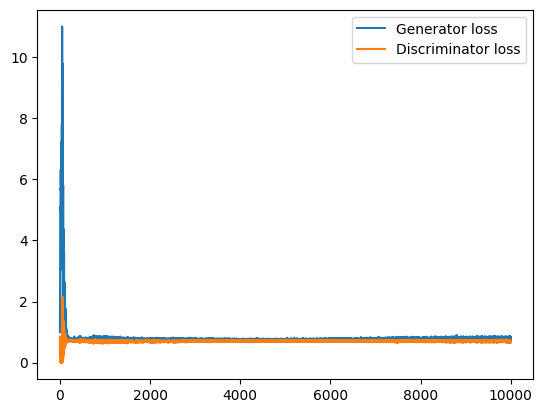

In [12]:
#plot the losses
plt.plot(g_losses,label='Generator loss')
plt.plot(d_losses,label='Discriminator loss')
plt.legend()

In [13]:
!ls gan_images

0.png  1000.png  2000.png  3000.png  4000.png  5000.png  6000.png  7000.png  8000.png  9000.png


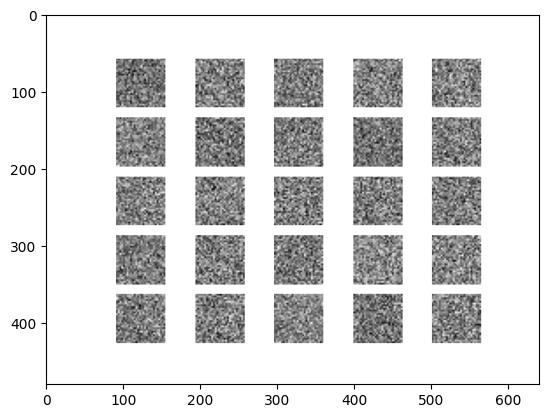

In [14]:
from skimage.io import imread
a=imread('gan_images/0.png')
plt.imshow(a)

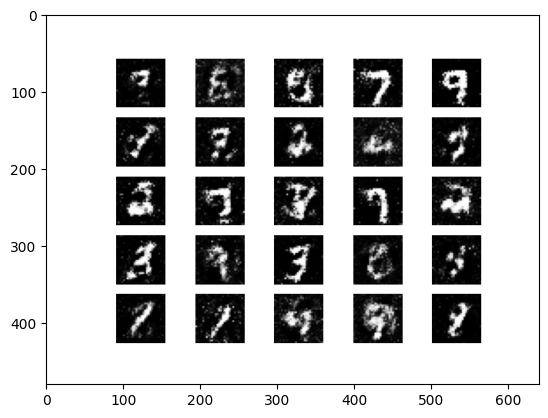

In [20]:
a=imread('gan_images/2000.png')
plt.imshow(a)

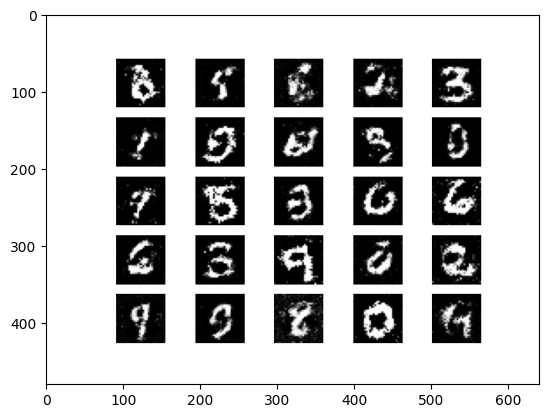

In [21]:
a=imread('gan_images/4000.png')
plt.imshow(a)

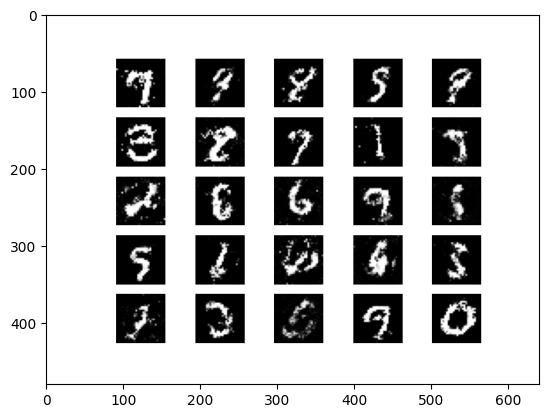

In [22]:
a=imread('gan_images/6000.png')
plt.imshow(a)

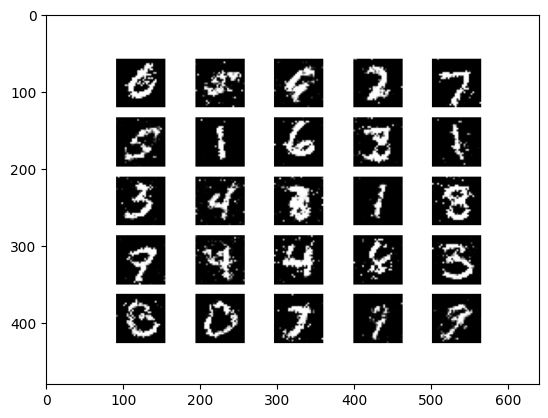

In [23]:
a=imread('gan_images/9000.png')
plt.imshow(a)